In [125]:
# take 10% of images from each class to validation

In [126]:
# there are B&W images in data!

In [127]:
import os
from datetime import datetime
from typing import Tuple

from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset

import torch
from torch import nn

from torch import optim
import torch.nn.functional as F

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

### Data

In [128]:
class TinyImageNetDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 annotations: list[Tuple[str, str]],
                 transform=None, 
                 target_transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        file_name, label = self.annotations[idx]
        img_path = os.path.join(self.img_dir, label, 'images', file_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [129]:
# TEMP. check with data
source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'
from pathlib import Path
img_dir = Path(source_folder)
img_dir.exists()
# for c in img_dir.iterdir():
    # for f in (c / "images").iterdir():
        # print(f)
        # break
    # break

# for class_name in img_dir.iterdir():
    # print(len(list((class_name / "images").iterdir())))


# 

True

In [130]:
# for debugging - will remove
N_CLASSES_TO_USE = 200

source_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/train'

train_split = []
val_split = []

# TODO ? maybe use cross-validation somehow? Looks like model will never train on last 50 images. Or it is okay?
class_names = os.listdir(source_folder)
for class_name in class_names[:N_CLASSES_TO_USE]:
    file_names = os.listdir(f'{source_folder}/{class_name}/images')
    file_ids = [int(name.split('.')[0].split('_')[1]) for name in file_names]

    train_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] < 450]
    val_names = [file_names[i] for i in range(len(file_names)) if file_ids[i] >= 450]
    # print(f"val_names:{val_names}")

    train_split.extend((name, class_name) for name in train_names)
    val_split.extend((name, class_name) for name in val_names)

In [131]:
print(train_split)
print(train_split[0])
len(train_split), len(val_split)

[('n02058221_225.JPEG', 'n02058221'), ('n02058221_361.JPEG', 'n02058221'), ('n02058221_325.JPEG', 'n02058221'), ('n02058221_287.JPEG', 'n02058221'), ('n02058221_131.JPEG', 'n02058221'), ('n02058221_140.JPEG', 'n02058221'), ('n02058221_33.JPEG', 'n02058221'), ('n02058221_249.JPEG', 'n02058221'), ('n02058221_308.JPEG', 'n02058221'), ('n02058221_137.JPEG', 'n02058221'), ('n02058221_150.JPEG', 'n02058221'), ('n02058221_116.JPEG', 'n02058221'), ('n02058221_323.JPEG', 'n02058221'), ('n02058221_179.JPEG', 'n02058221'), ('n02058221_391.JPEG', 'n02058221'), ('n02058221_46.JPEG', 'n02058221'), ('n02058221_331.JPEG', 'n02058221'), ('n02058221_274.JPEG', 'n02058221'), ('n02058221_26.JPEG', 'n02058221'), ('n02058221_358.JPEG', 'n02058221'), ('n02058221_145.JPEG', 'n02058221'), ('n02058221_127.JPEG', 'n02058221'), ('n02058221_141.JPEG', 'n02058221'), ('n02058221_117.JPEG', 'n02058221'), ('n02058221_160.JPEG', 'n02058221'), ('n02058221_314.JPEG', 'n02058221'), ('n02058221_42.JPEG', 'n02058221'), ('n0

(90000, 10000)

In [132]:
# TODO ? why and what we are doing by T.Normalize
train_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# TODO ? why do we need dict with IDs and back
class_name_to_id_dict = {name: i for i, name in enumerate(class_names)}
class_id_to_name_dict = {i: name for name, i in class_name_to_id_dict.items()}

label_to_id_transform = lambda name: class_name_to_id_dict[name]

In [133]:
train_dataset = TinyImageNetDataset(source_folder,
                                    train_split,
                                    transform=train_img_transform,
                                    target_transform=label_to_id_transform
                                    )

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [134]:
# TODO ? do we need also to shuffle the val dataset?
val_dataset = TinyImageNetDataset(source_folder,
                                  val_split,
                                  transform=val_img_transform,
                                  target_transform=label_to_id_transform
                                    )

val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [135]:
# TODO ? what is Y here? why it is 128 values. It should be class value, no?
X, Y = next(iter(train_dataloader))
X.shape, Y.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

---

### Model

In [136]:
# TODO ? just fun, why 42?
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [137]:
class CnnBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, *args, n_conv_layers = 1):
    super().__init__()

    layers = [
        nn.Conv2d(in_channels,
                  out_channels,
                  kernel_size=kernel_size,
                  padding=kernel_size // 2),
        nn.ReLU()
    ]

    for _ in range(n_conv_layers - 1):
        layers.append(nn.Conv2d(out_channels,
                                out_channels,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2))
        layers.append(nn.ReLU())

    self.conv_layers = nn.Sequential(*layers)
    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    x = self.conv_layers(x)
    x = self.pool(x)
    return x


class FcBlock(nn.Module):
    def __init__(self, in_shape: int, 
                 out_shape: int, 
                 do_batchnorm: bool = True, 
                 activation: nn.Module = None):
        super().__init__()
        layers = []

        if do_batchnorm:
            layers.append(nn.BatchNorm1d(in_shape))

        layers.append(nn.Linear(in_shape, out_shape))

        if activation is not None:
            layers.append(activation)
            
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [138]:
# 3x64x64 -> (conv1) -> 32x32x32 -> (conv2) -> 64x16x16 -> (conv3) -> 128x8x8 -> (conv4) -> 64x4x4=1024

In [139]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CnnBlock(3, 32, kernel_size=5)
        self.conv2 = CnnBlock(32, 64, kernel_size=5)
        self.conv3 = CnnBlock(64, 128, kernel_size=3)
        self.conv4 = CnnBlock(128, 64, kernel_size=3)

        self.drop1 = nn.Dropout(p=0.2)
        self.fc1 = FcBlock(64 * 4 * 4, 512, do_batchnorm=True, activation=nn.ReLU())
        
        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = FcBlock(512, 200, do_batchnorm=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = torch.flatten(x, 1)

        x = self.drop1(x)
        x = self.fc1(x)

        x = self.drop2(x)
        x = self.fc2(x)
        return x

In [140]:
model = BaselineModel()

out = model(X)
out.shape

torch.Size([128, 200])

---

### Train

In [141]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [142]:
set_seed(123)

model = BaselineModel()
model.to(DEVICE)

Random seed set as 123


BaselineModel(
  (conv1): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): CnnBlock(
    (conv_layers): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop1

In [143]:
train_config = {
    'n_epochs': 25,
    'lr': 0.005,
    'batch_size': 128,
}

optimizer = optim.Adam(model.parameters(), lr=train_config['lr'])
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

best_checkpoint_path = '../working/best.pth'

In [144]:
def do_train_epoch(model: nn.Module, 
                   criterion: nn.Module,
                   optimizer,
                   train_loader: DataLoader, 
                   verbose: int = -1) -> Tuple[float, float]:
    total_steps = len(train_dataloader)
    
    running_loss, step = 0, 0
    n_correct_predictions, total_predictions = 0, 0
    for X, Y in train_loader:
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        optimizer.zero_grad()
    
        preds = model(X).cuda()
        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        step += 1

        if verbose > 0 and step % verbose == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps}: train loss = {round(running_loss / step, 5)}")

        total_predictions += len(Y)

        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)
        n_correct_predictions += (predicted_labels == Y).sum().item()
    
    avg_loss = round(running_loss / step, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)
    
    return avg_loss, accuracy

In [145]:
def do_val_epoch(model: nn.Module,
                 criterion: nn.Module,
                 val_loader: DataLoader) -> Tuple[float, float]:
    total_steps = len(val_loader)
    
    running_loss = 0
    n_correct_predictions, total_predictions = 0, 0
    
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            preds = model(X).cuda()
            loss = criterion(preds, Y)
    
            running_loss += loss.item()
            total_predictions += len(Y)
    
            probs = F.softmax(preds, dim=1)
            predicted_labels = torch.argmax(probs, dim=1)
            n_correct_predictions += (predicted_labels == Y).sum().item()

    avg_loss = round(running_loss / total_steps, 5)
    accuracy = round(n_correct_predictions / total_predictions, 5)

    print(f'VALIDATION LOSS = {avg_loss}, VALIDATION ACCURACY = {accuracy}')
    
    return avg_loss, accuracy
          

In [146]:
def plot_history(history: dict):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history['train_loss'], marker='o', label='Train Loss')
    ax[0].plot(history['test_loss'], marker='o', label='Test Loss')
    ax[0].set_title('Loss per epoch')
    ax[0].legend()
    
    ax[1].plot(history['train_accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(history['test_accuracy'], marker='o', label='Test Accuracy')
    ax[1].set_title('Accuracy per epoch')
    ax[1].legend()
    
    plt.show()


 		 ------------------------------ EPOCH: 1 ------------------------------


[18:59:25] Step 20/704: train loss = 5.57893
[18:59:26] Step 40/704: train loss = 5.53691
[18:59:27] Step 60/704: train loss = 5.48707
[18:59:28] Step 80/704: train loss = 5.42958
[18:59:29] Step 100/704: train loss = 5.38124
[18:59:31] Step 120/704: train loss = 5.33398
[18:59:32] Step 140/704: train loss = 5.28956
[18:59:33] Step 160/704: train loss = 5.24496
[18:59:34] Step 180/704: train loss = 5.19456
[18:59:35] Step 200/704: train loss = 5.15861
[18:59:36] Step 220/704: train loss = 5.12344
[18:59:37] Step 240/704: train loss = 5.08847
[18:59:38] Step 260/704: train loss = 5.05524
[18:59:39] Step 280/704: train loss = 5.01999
[18:59:40] Step 300/704: train loss = 4.98856
[18:59:41] Step 320/704: train loss = 4.96261
[18:59:42] Step 340/704: train loss = 4.93391
[18:59:43] Step 360/704: train loss = 4.9069
[18:59:44] Step 380/704: train loss = 4.8782
[18:59:45] Step 400/704: train loss = 4.85312
[18:59:46] Step 420/704: train loss = 4.82818
[18:59:47] Step 440/704: train loss = 4.

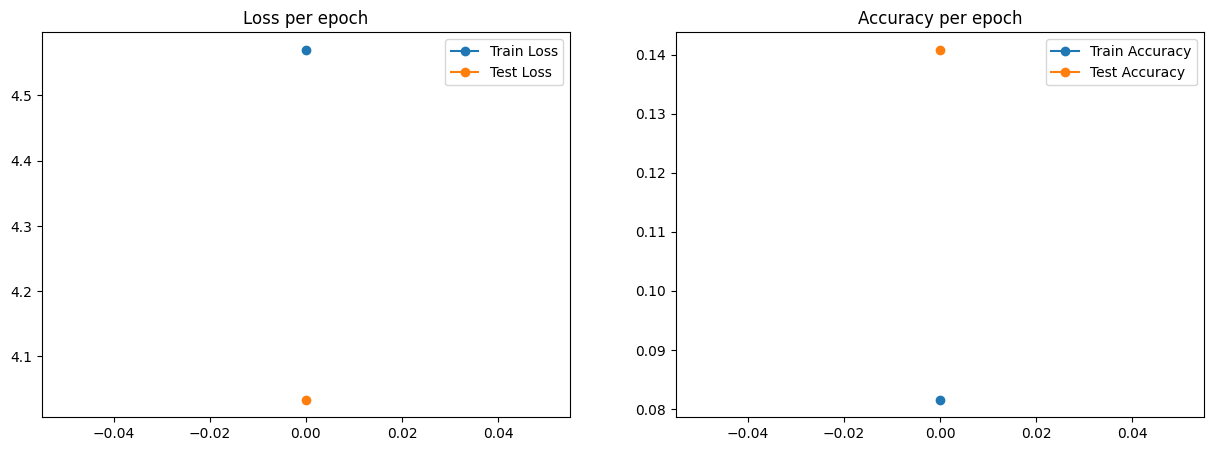

Saving best model

 		 ------------------------------ EPOCH: 2 ------------------------------
[19:00:04] Step 20/704: train loss = 3.97196
[19:00:05] Step 40/704: train loss = 3.97723
[19:00:06] Step 60/704: train loss = 3.96513
[19:00:07] Step 80/704: train loss = 3.945
[19:00:08] Step 100/704: train loss = 3.94545
[19:00:09] Step 120/704: train loss = 3.93716
[19:00:10] Step 140/704: train loss = 3.94035
[19:00:11] Step 160/704: train loss = 3.9281
[19:00:12] Step 180/704: train loss = 3.92112
[19:00:13] Step 200/704: train loss = 3.91987
[19:00:14] Step 220/704: train loss = 3.91898
[19:00:15] Step 240/704: train loss = 3.90997
[19:00:16] Step 260/704: train loss = 3.90138
[19:00:17] Step 280/704: train loss = 3.89526
[19:00:18] Step 300/704: train loss = 3.89325
[19:00:19] Step 320/704: train loss = 3.88884
[19:00:20] Step 340/704: train loss = 3.883
[19:00:21] Step 360/704: train loss = 3.8763
[19:00:22] Step 380/704: train loss = 3.86779
[19:00:23] Step 400/704: train loss = 3.86

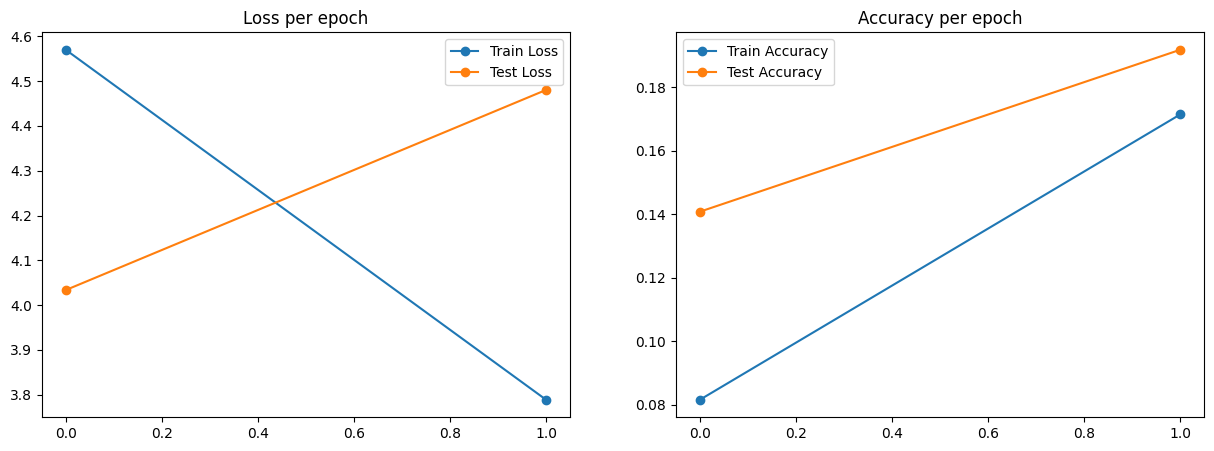

Validation loss didn't improve

 		 ------------------------------ EPOCH: 3 ------------------------------
[19:00:43] Step 20/704: train loss = 3.56802
[19:00:44] Step 40/704: train loss = 3.5029
[19:00:45] Step 60/704: train loss = 3.5086
[19:00:46] Step 80/704: train loss = 3.48244
[19:00:47] Step 100/704: train loss = 3.47606
[19:00:48] Step 120/704: train loss = 3.48298
[19:00:49] Step 140/704: train loss = 3.49479
[19:00:50] Step 160/704: train loss = 3.48211
[19:00:51] Step 180/704: train loss = 3.48334
[19:00:52] Step 200/704: train loss = 3.48971
[19:00:53] Step 220/704: train loss = 3.49313
[19:00:54] Step 240/704: train loss = 3.49587
[19:00:55] Step 260/704: train loss = 3.49399
[19:00:56] Step 280/704: train loss = 3.49786
[19:00:57] Step 300/704: train loss = 3.494
[19:00:58] Step 320/704: train loss = 3.49541
[19:00:59] Step 340/704: train loss = 3.49482
[19:01:00] Step 360/704: train loss = 3.4918
[19:01:01] Step 380/704: train loss = 3.49014
[19:01:02] Step 400/704: tra

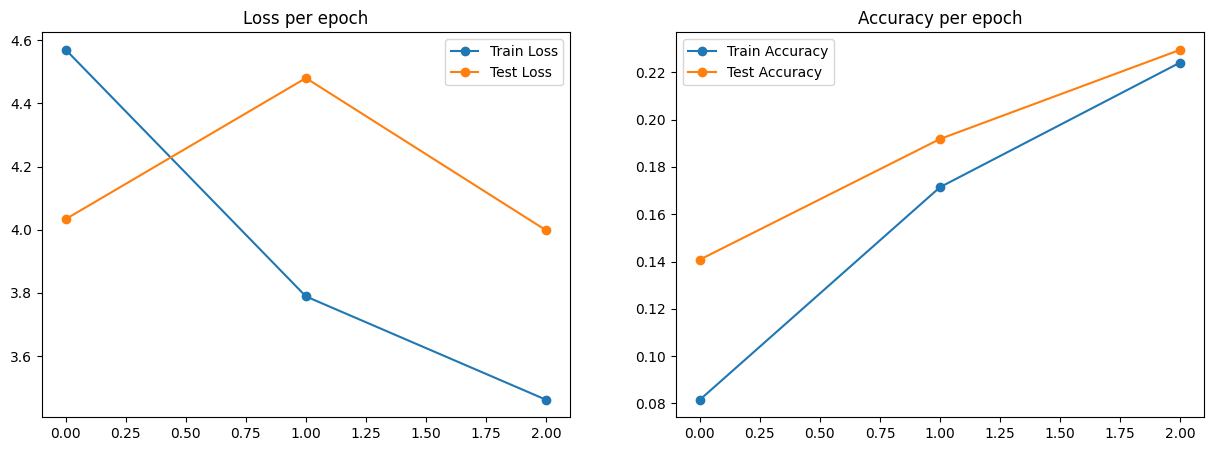

Saving best model

 		 ------------------------------ EPOCH: 4 ------------------------------
[19:01:22] Step 20/704: train loss = 3.50781
[19:01:23] Step 40/704: train loss = 3.71616
[19:01:24] Step 60/704: train loss = 3.69145
[19:01:25] Step 80/704: train loss = 3.64859
[19:01:26] Step 100/704: train loss = 3.61233
[19:01:27] Step 120/704: train loss = 3.57603
[19:01:28] Step 140/704: train loss = 3.54346
[19:01:29] Step 160/704: train loss = 3.52356
[19:01:30] Step 180/704: train loss = 3.5015
[19:01:31] Step 200/704: train loss = 3.48872
[19:01:32] Step 220/704: train loss = 3.47964
[19:01:33] Step 240/704: train loss = 3.46947
[19:01:34] Step 260/704: train loss = 3.45821
[19:01:34] Step 280/704: train loss = 3.4494
[19:01:35] Step 300/704: train loss = 3.43913
[19:01:36] Step 320/704: train loss = 3.43326
[19:01:37] Step 340/704: train loss = 3.42501
[19:01:38] Step 360/704: train loss = 3.41717
[19:01:39] Step 380/704: train loss = 3.41078
[19:01:40] Step 400/704: train loss = 

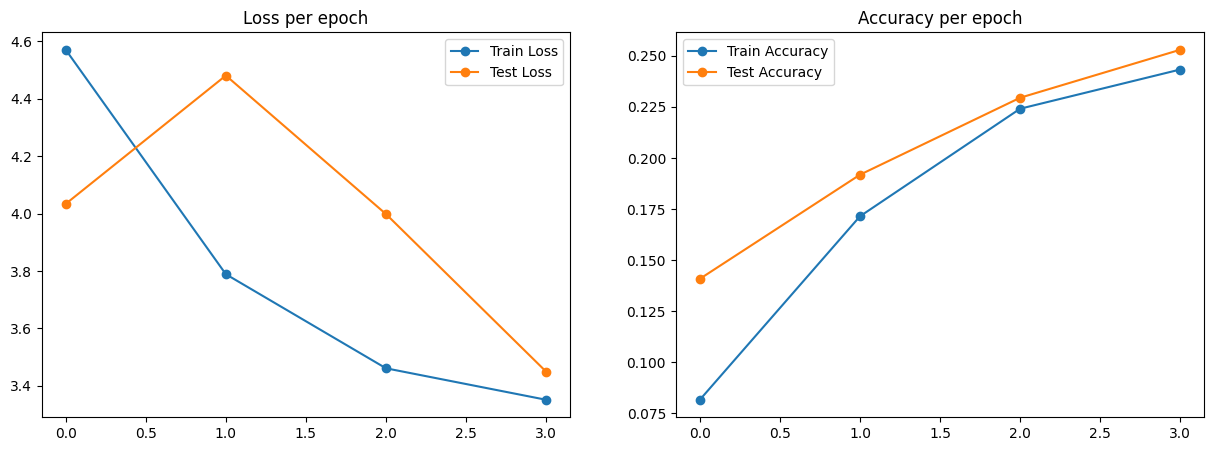

Saving best model

 		 ------------------------------ EPOCH: 5 ------------------------------
[19:02:00] Step 20/704: train loss = 3.1308
[19:02:01] Step 40/704: train loss = 3.08029
[19:02:02] Step 60/704: train loss = 3.08106
[19:02:03] Step 80/704: train loss = 3.08402
[19:02:04] Step 100/704: train loss = 3.08941
[19:02:05] Step 120/704: train loss = 3.09404
[19:02:07] Step 140/704: train loss = 3.09203
[19:02:08] Step 160/704: train loss = 3.09807
[19:02:09] Step 180/704: train loss = 3.1012
[19:02:10] Step 200/704: train loss = 3.09919
[19:02:11] Step 220/704: train loss = 3.09572
[19:02:12] Step 240/704: train loss = 3.09613
[19:02:13] Step 260/704: train loss = 3.09656
[19:02:14] Step 280/704: train loss = 3.09527
[19:02:15] Step 300/704: train loss = 3.09712
[19:02:16] Step 320/704: train loss = 3.09916
[19:02:17] Step 340/704: train loss = 3.09926
[19:02:18] Step 360/704: train loss = 3.09695
[19:02:19] Step 380/704: train loss = 3.0982
[19:02:20] Step 400/704: train loss = 3

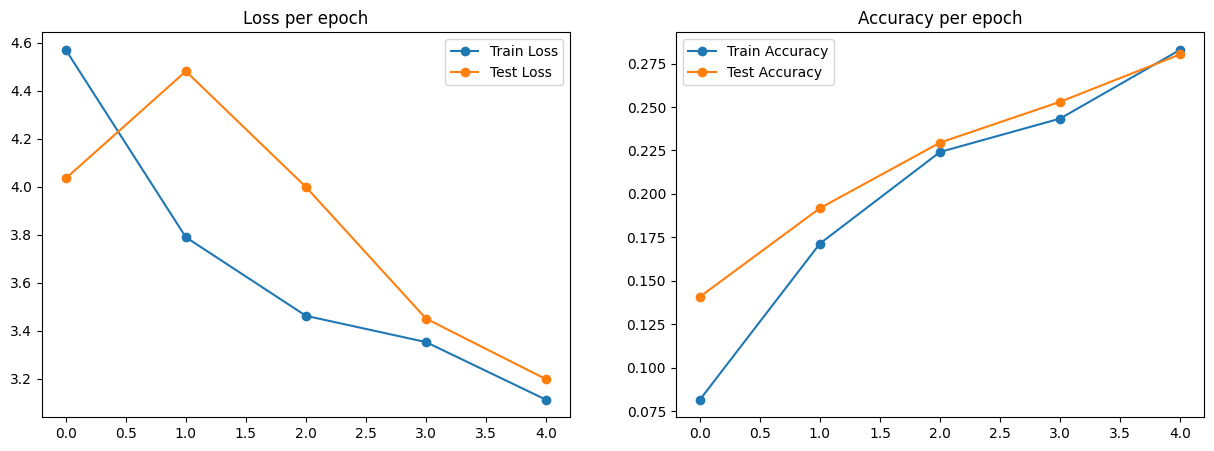

Saving best model

 		 ------------------------------ EPOCH: 6 ------------------------------
[19:02:40] Step 20/704: train loss = 2.83978
[19:02:41] Step 40/704: train loss = 2.80917
[19:02:42] Step 60/704: train loss = 2.81197
[19:02:43] Step 80/704: train loss = 2.82902
[19:02:44] Step 100/704: train loss = 2.83958
[19:02:45] Step 120/704: train loss = 2.8698
[19:02:46] Step 140/704: train loss = 2.87279
[19:02:47] Step 160/704: train loss = 2.8755
[19:02:48] Step 180/704: train loss = 2.87521
[19:02:49] Step 200/704: train loss = 2.87764
[19:02:50] Step 220/704: train loss = 2.88207
[19:02:51] Step 240/704: train loss = 2.88878
[19:02:52] Step 260/704: train loss = 2.89075
[19:02:53] Step 280/704: train loss = 2.89417
[19:02:54] Step 300/704: train loss = 2.89873
[19:02:55] Step 320/704: train loss = 2.90134
[19:02:56] Step 340/704: train loss = 2.90305
[19:02:57] Step 360/704: train loss = 2.90915
[19:02:58] Step 380/704: train loss = 2.91072
[19:02:59] Step 400/704: train loss = 

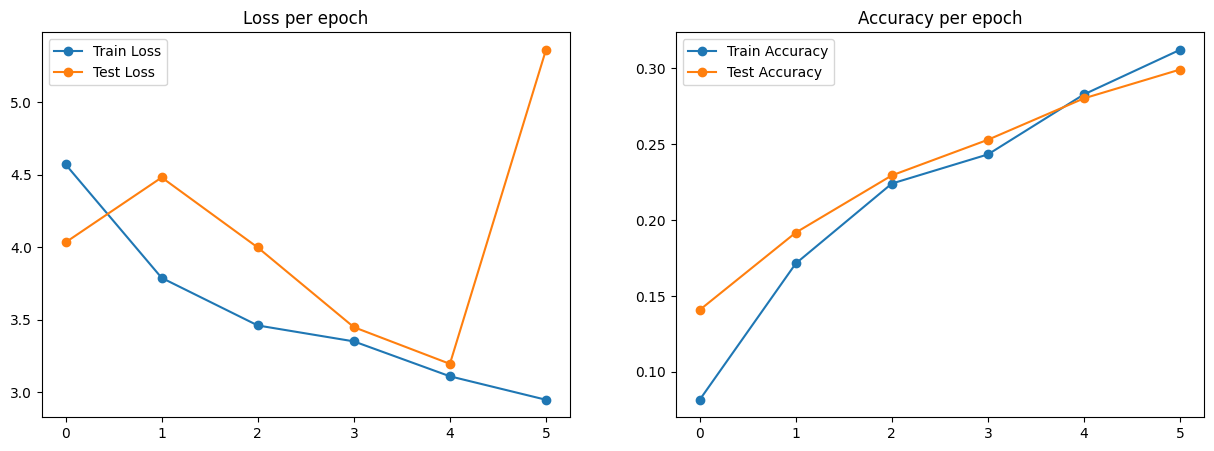

Validation loss didn't improve

 		 ------------------------------ EPOCH: 7 ------------------------------
[19:03:19] Step 20/704: train loss = 2.73661
[19:03:20] Step 40/704: train loss = 2.69548
[19:03:21] Step 60/704: train loss = 2.70397
[19:03:22] Step 80/704: train loss = 2.69749
[19:03:23] Step 100/704: train loss = 2.71565
[19:03:24] Step 120/704: train loss = 2.71769
[19:03:25] Step 140/704: train loss = 2.72933
[19:03:26] Step 160/704: train loss = 2.73952
[19:03:27] Step 180/704: train loss = 2.74958
[19:03:28] Step 200/704: train loss = 2.75508
[19:03:29] Step 220/704: train loss = 2.7609
[19:03:30] Step 240/704: train loss = 2.76544
[19:03:32] Step 260/704: train loss = 2.77312
[19:03:33] Step 280/704: train loss = 2.77535
[19:03:34] Step 300/704: train loss = 2.77515
[19:03:35] Step 320/704: train loss = 2.78067
[19:03:36] Step 340/704: train loss = 2.78547
[19:03:37] Step 360/704: train loss = 2.78764
[19:03:38] Step 380/704: train loss = 2.78643
[19:03:39] Step 400/704:

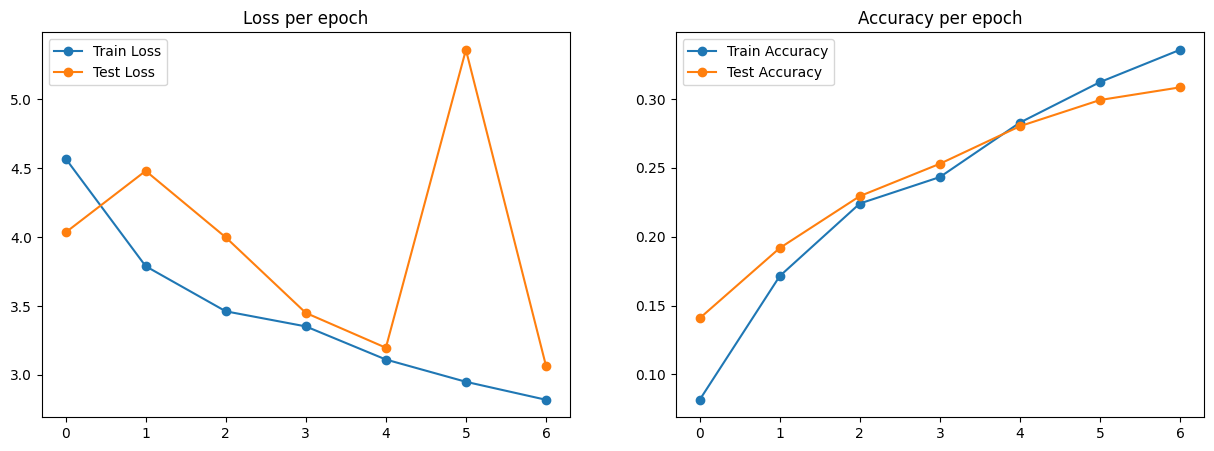

Saving best model

 		 ------------------------------ EPOCH: 8 ------------------------------
[19:03:59] Step 20/704: train loss = 2.72992
[19:04:00] Step 40/704: train loss = 2.63813
[19:04:01] Step 60/704: train loss = 2.65676
[19:04:02] Step 80/704: train loss = 2.64442
[19:04:03] Step 100/704: train loss = 2.6396
[19:04:04] Step 120/704: train loss = 2.64925
[19:04:05] Step 140/704: train loss = 2.64664
[19:04:06] Step 160/704: train loss = 2.6383
[19:04:07] Step 180/704: train loss = 2.64692
[19:04:09] Step 200/704: train loss = 2.65054
[19:04:10] Step 220/704: train loss = 2.66358
[19:04:11] Step 240/704: train loss = 2.66633
[19:04:12] Step 260/704: train loss = 2.66603
[19:04:13] Step 280/704: train loss = 2.6647
[19:04:14] Step 300/704: train loss = 2.66304
[19:04:15] Step 320/704: train loss = 2.66515
[19:04:16] Step 340/704: train loss = 2.66663
[19:04:17] Step 360/704: train loss = 2.67116
[19:04:18] Step 380/704: train loss = 2.67514
[19:04:19] Step 400/704: train loss = 2

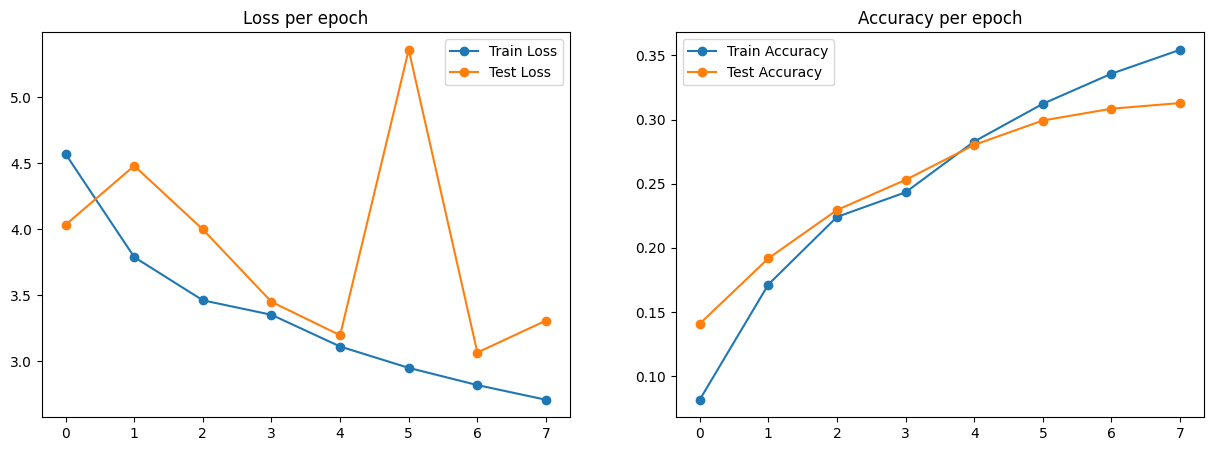

Validation loss didn't improve

 		 ------------------------------ EPOCH: 9 ------------------------------
[19:04:40] Step 20/704: train loss = 2.50294
[19:04:41] Step 40/704: train loss = 2.44938
[19:04:42] Step 60/704: train loss = 2.46072
[19:04:43] Step 80/704: train loss = 2.48097
[19:04:44] Step 100/704: train loss = 2.47312
[19:04:45] Step 120/704: train loss = 2.48095
[19:04:46] Step 140/704: train loss = 2.48578
[19:04:47] Step 160/704: train loss = 2.48788
[19:04:48] Step 180/704: train loss = 2.49746
[19:04:50] Step 200/704: train loss = 2.50216
[19:04:51] Step 220/704: train loss = 2.51005
[19:04:52] Step 240/704: train loss = 2.52306
[19:04:53] Step 260/704: train loss = 2.52801
[19:04:54] Step 280/704: train loss = 2.53489
[19:04:55] Step 300/704: train loss = 2.53812
[19:04:56] Step 320/704: train loss = 2.53996
[19:04:57] Step 340/704: train loss = 2.54151
[19:04:58] Step 360/704: train loss = 2.54533
[19:04:59] Step 380/704: train loss = 2.5512
[19:05:00] Step 400/704:

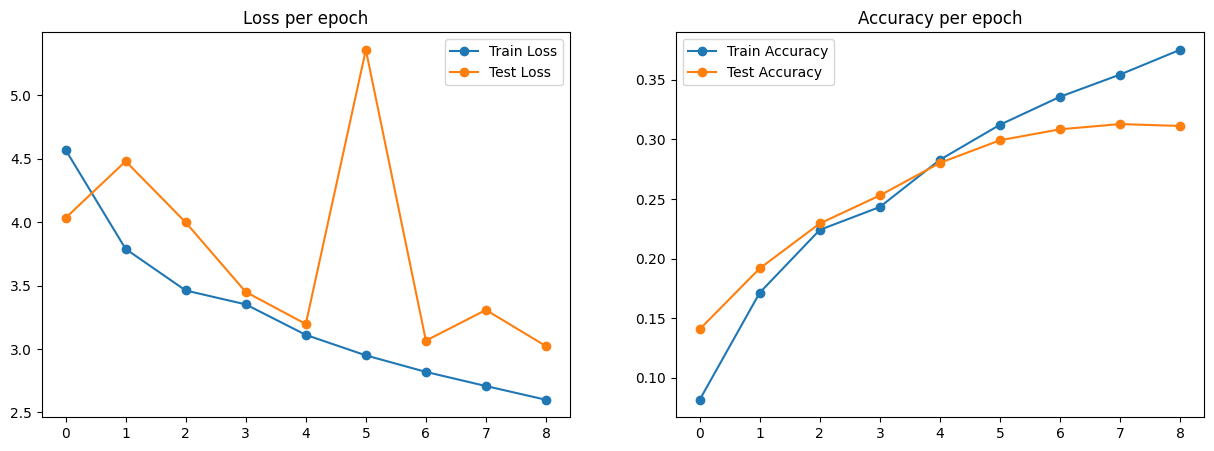

Saving best model

 		 ------------------------------ EPOCH: 10 ------------------------------
[19:05:21] Step 20/704: train loss = 2.56686
[19:05:22] Step 40/704: train loss = 2.49485
[19:05:23] Step 60/704: train loss = 2.45998
[19:05:24] Step 80/704: train loss = 2.44612
[19:05:25] Step 100/704: train loss = 2.43899
[19:05:26] Step 120/704: train loss = 2.43894
[19:05:27] Step 140/704: train loss = 2.43438
[19:05:28] Step 160/704: train loss = 2.42662
[19:05:29] Step 180/704: train loss = 2.43203
[19:05:30] Step 200/704: train loss = 2.43146
[19:05:31] Step 220/704: train loss = 2.42669
[19:05:32] Step 240/704: train loss = 2.43468
[19:05:33] Step 260/704: train loss = 2.43711
[19:05:34] Step 280/704: train loss = 2.44893
[19:05:35] Step 300/704: train loss = 2.45383
[19:05:36] Step 320/704: train loss = 2.45684
[19:05:38] Step 340/704: train loss = 2.45759
[19:05:39] Step 360/704: train loss = 2.46181
[19:05:40] Step 380/704: train loss = 2.46417
[19:05:41] Step 400/704: train loss

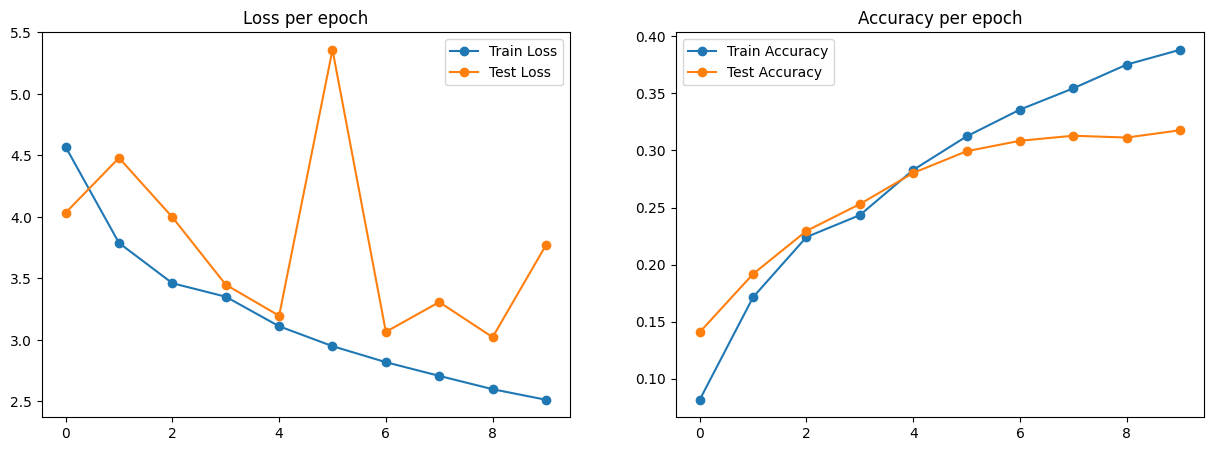

Validation loss didn't improve

 		 ------------------------------ EPOCH: 11 ------------------------------
[19:06:01] Step 20/704: train loss = 2.29569
[19:06:02] Step 40/704: train loss = 2.29036
[19:06:04] Step 60/704: train loss = 2.30565
[19:06:05] Step 80/704: train loss = 2.30496
[19:06:06] Step 100/704: train loss = 2.29777
[19:06:07] Step 120/704: train loss = 2.30214
[19:06:08] Step 140/704: train loss = 2.31417
[19:06:09] Step 160/704: train loss = 2.32064
[19:06:10] Step 180/704: train loss = 2.32426
[19:06:11] Step 200/704: train loss = 2.32146
[19:06:12] Step 220/704: train loss = 2.32893
[19:06:13] Step 240/704: train loss = 2.33282
[19:06:14] Step 260/704: train loss = 2.33231
[19:06:15] Step 280/704: train loss = 2.33869
[19:06:16] Step 300/704: train loss = 2.34605
[19:06:17] Step 320/704: train loss = 2.34969
[19:06:18] Step 340/704: train loss = 2.3552
[19:06:20] Step 360/704: train loss = 2.35974
[19:06:21] Step 380/704: train loss = 2.36811
[19:06:22] Step 400/704

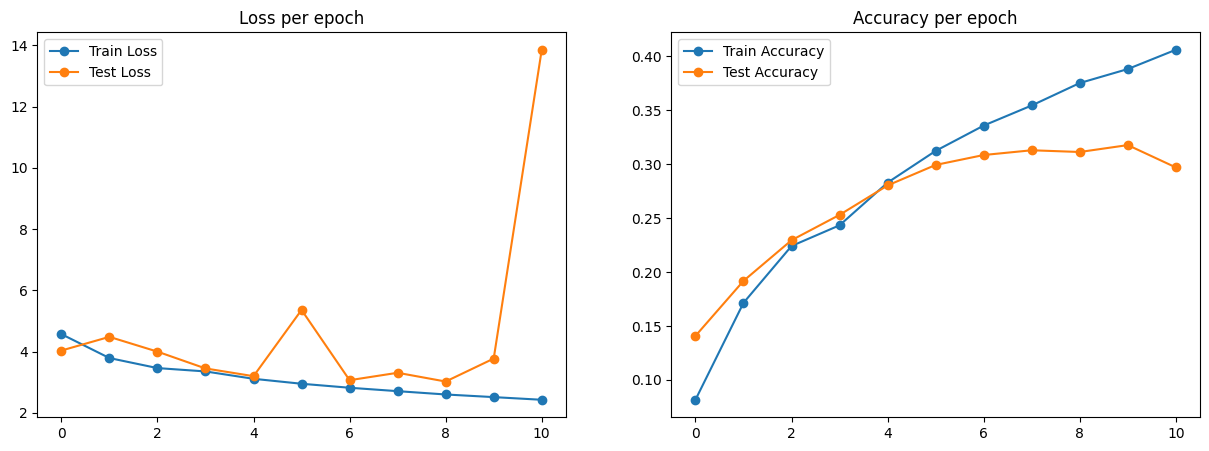

Validation loss didn't improve
EARLY STOPPING: min test_loss 3.0223, last 2 epochs min: 3.77166
Restoring the model at epoch 8: test_accuracy = 0.3113
Model successfully restored

 Final model is stored to model_epoch_8_test_acc_0.3113.pth


In [147]:
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
    
}

for epoch in range(train_config['n_epochs']):
    print('\n', '\t\t', '-' * 30, f"EPOCH: {epoch + 1}", '-' * 30)

    # Train
    model.train()
    model.to(DEVICE)
    train_avg_loss, train_accuracy = do_train_epoch(model, 
                                                    criterion, 
                                                    optimizer, 
                                                    train_dataloader, 
                                                    verbose=20)

    history['train_loss'].append(train_avg_loss)
    history['train_accuracy'].append(train_accuracy)

    # Val
    model.eval()
    val_avg_loss, val_accuracy = do_val_epoch(model, 
                                              criterion, 
                                              val_dataloader)
    history['test_loss'].append(val_avg_loss)
    history['test_accuracy'].append(val_accuracy)

    # on_epoch_end events
    plot_history(history)
    
    # model checkpointing
    if history['test_loss'][-1] == min(history['test_loss']):
        print('Saving best model')
        torch.save(model.state_dict(), best_checkpoint_path)
    else:
        print("Validation loss didn't improve")

    # early stopping
    if min(history['test_loss'][-2:]) > min(history['test_loss']):
        best_epoch = np.argmin(history['test_loss'])
        best_test_accuracy = history['test_accuracy'][best_epoch]

        print(f'EARLY STOPPING: min test_loss {min(history["test_loss"])}, last 2 epochs min: {min(history["test_loss"][-2:])}')
        print(f'Restoring the model at epoch {best_epoch}: test_accuracy = {best_test_accuracy}')

        model.load_state_dict(torch.load(best_checkpoint_path, weights_only=True))
        print('Model successfully restored')
        break

    # lr_adjustments (todo)


# saving the best model to hard storage
model_file_name = f'model_epoch_{best_epoch}_test_acc_{best_test_accuracy}.pth'
torch.save(model.state_dict(), f'../working/{model_file_name}')

print(f'\n Final model is stored to {model_file_name}')
os.remove(best_checkpoint_path)

### Make a prediction and prepare submission file

In [148]:
import pandas as pd

In [149]:
class TestDataset(Dataset):
    def __init__(self, 
                 img_dir: str, 
                 file_names: list[str],
                 transform=None):
        self.img_dir = img_dir
        self.file_names = file_names
        self.image_ids = [int(n.split('.')[0].split('_')[1]) for n in file_names]
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert('RGB')

        img_id = self.image_ids[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, img_id

In [150]:
test_folder = '../input/flg-ml-24-cnn/tiny-imagenet-200/val'
test_image_names = sorted(os.listdir(f'{test_folder}/images'))
len(test_image_names)

10000

In [151]:
test_dataset = TestDataset(f'{test_folder}/images', test_image_names, transform=val_img_transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [152]:
model.eval()

test_predictions = pd.Series([-1] * len(test_dataset))

total_steps = len(test_dataloader)
step = 0

with torch.no_grad():
    for X, img_ids in test_dataloader:
        preds = model(X.to(DEVICE)).cpu()
        
        probs = F.softmax(preds, dim=1)
        predicted_labels = torch.argmax(probs, dim=1)

        # predicted_labels = torch.tensor([0] * X.shape[0])

        test_predictions.loc[img_ids] = predicted_labels.numpy()
        step += 1

        if step % 10 == 0:
            cur_time = datetime.now().strftime("%H:%M:%S")
            print(f"[{cur_time}] Step {step}/{total_steps} done")

[19:06:42] Step 10/79 done
[19:06:43] Step 20/79 done
[19:06:43] Step 30/79 done
[19:06:44] Step 40/79 done
[19:06:44] Step 50/79 done
[19:06:44] Step 60/79 done


[19:06:45] Step 70/79 done


In [153]:
test_predictions_df = (test_predictions
                       .reset_index()
                       .rename(columns={'index': 'ID', 0: 'class'}))
test_predictions_df.head()

ID  class
0   0     62
1   1    135
2   2     66
3   3    142
4   4     92

In [154]:
# here we will do some analysis to ensure predictions file looks reasonable
(test_predictions_df['class'] < 0).sum()

np.int64(0)

In [155]:
test_predictions_df['class'].value_counts()

class
125    143
64     134
69     122
4      122
60     118
      ... 
118     10
199      9
30       7
164      7
198      6
Name: count, Length: 200, dtype: int64

In [156]:
test_predictions_df['class'] = test_predictions_df['class'].map(class_id_to_name_dict)
test_predictions_df['ID'] = test_predictions_df['ID'].apply(lambda v: f'val_{v}.JPEG')

In [157]:
test_predictions_df.head()

ID      class
0  val_0.JPEG  n03444034
1  val_1.JPEG  n01784675
2  val_2.JPEG  n03014705
3  val_3.JPEG  n02808440
4  val_4.JPEG  n04099969

In [158]:
test_predictions_df.to_csv(f'../working/submission_{model_file_name}.csv', index=False)